In [3]:
import pandas as pd
import urllib
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 14, 4

# <center>Tarea 2 Máquinas de Aprendizaje</center>

<center>
Patricio Horth M.<br>
Víctor Zúñiga M.<br>

2 de Noviembre de 2017
</center>



In [7]:
train_data_url = "https://statweb.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train"
test_data_url = "https://statweb.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test"
train_data_f = urllib.request.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.request.urlretrieve(test_data_url, "test_data.csv")
train_df = pd.DataFrame.from_csv('train_data.csv',header=0,index_col=0)
test_df = pd.DataFrame.from_csv('test_data.csv',header=0,index_col=0)

In [23]:
train_df.head()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
1,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
2,2,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
3,3,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
4,4,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
5,5,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396


In [24]:
test_df.tail()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
458,7,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147
459,8,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301
460,9,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500
461,10,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390
462,11,-3.291,2.324,-0.679,0.285,0.441,0.557,-0.227,0.115,-1.046,0.697


In [21]:
print("El conjunto de entrenamiento tiene", train_df.shape[0], "registros")

El conjunto de entrenamiento tiene 528 registros


In [22]:
print("El conjunto de entrenamiento tiene", test_df.shape[0], "registros")

El conjunto de entrenamiento tiene 462 registros


In [38]:
from collections import Counter
Counter(train_df.y)

Counter({1: 48,
         2: 48,
         3: 48,
         4: 48,
         5: 48,
         6: 48,
         7: 48,
         8: 48,
         9: 48,
         10: 48,
         11: 48})

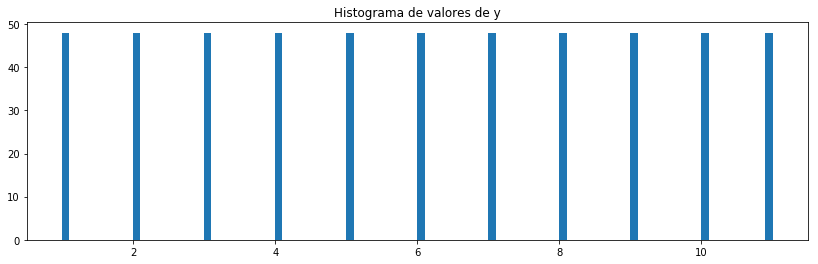

In [26]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma de valores de y")
plt.hist(train_df.y,bins=100)
plt.show()

In [39]:
from collections import Counter
Counter(train_df.y)

Counter({1: 48,
         2: 48,
         3: 48,
         4: 48,
         5: 48,
         6: 48,
         7: 48,
         8: 48,
         9: 48,
         10: 48,
         11: 48})

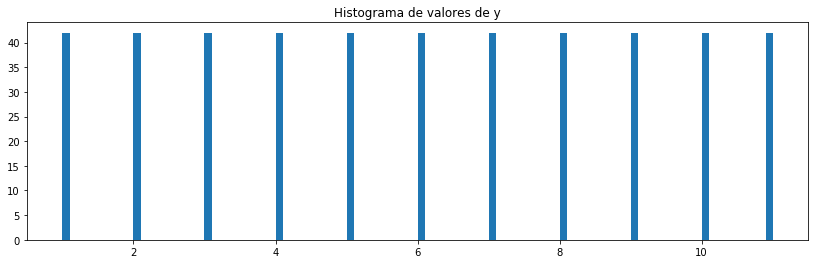

In [37]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma de valores de y")
plt.hist(test_df.y,bins=100)
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler
X = train_df.loc[:,'x.1':'x.10'].values
y = train_df.loc[:,'y'].values
Scaler = StandardScaler().fit(X)
X_std = Scaler.transform(X)

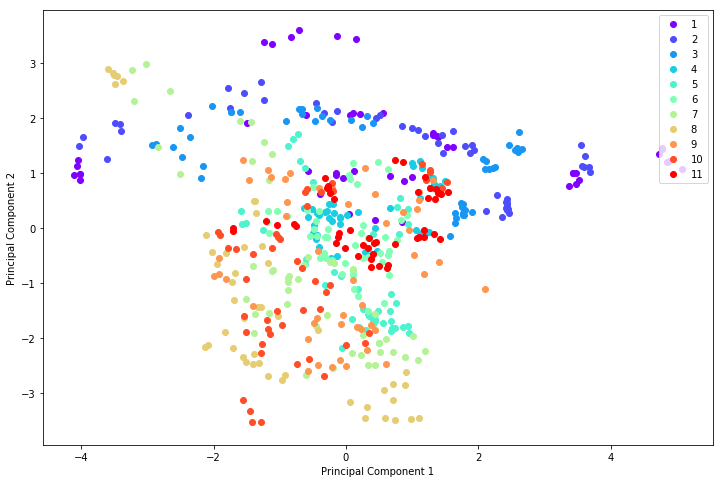

In [46]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sklearn_pca = PCA(n_components=2)
Xred_pca = sklearn_pca.fit_transform(X_std)
cmap = plt.cm.get_cmap("rainbow")
mclasses=(1,2,3,4,5,6,7,8,9,10,11)
mcolors = [cmap(i) for i in np.linspace(0,1,11)]
plt.figure(figsize=(12, 8))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_pca[y==lab, 0],Xred_pca[y==lab, 1],label=lab,c=col)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

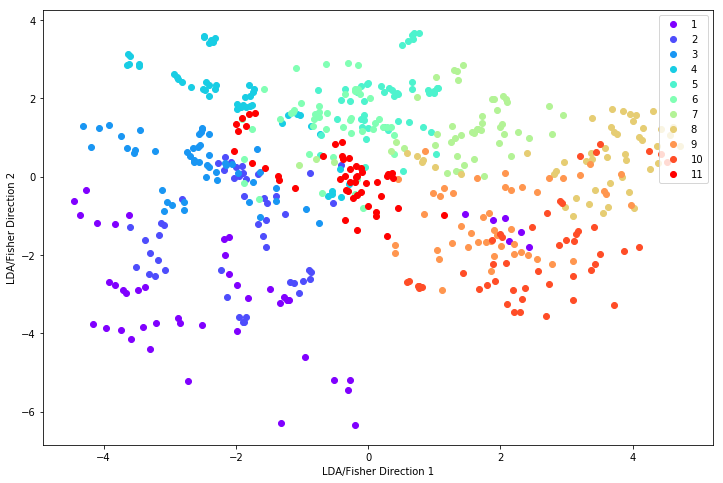

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sklearn_lda = LDA(n_components=2)
Xred_lda = sklearn_lda.fit_transform(X_std,y)
cmap = plt.cm.get_cmap("rainbow")
mclasses=(1,2,3,4,5,6,7,8,9,10,11)
mcolors = [cmap(i) for i in np.linspace(0,1,11)]
plt.figure(figsize=(12, 8))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_lda[y==lab, 0],Xred_lda[y==lab, 1],label=lab,c=col)
plt.xlabel('LDA/Fisher Direction 1')
plt.ylabel('LDA/Fisher Direction 2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

In [53]:
from collections import Counter
Counter(y)
y.shape[0]

list(set(y))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [62]:
import random

def get_probabilities(y):
    sum = y.shape[0]
    y_set = list(set(y))
    y_probabilities = []
    for i in y_set:
        y_probabilities.append( (list(y).count(i))/sum )
    return y_probabilities

print(get_probabilities(y))

def random_classifier(X,y):
    y_probabilities = get_probabilities(y)
    y_pred = []
    #for i in X:
    #    y_pred.append(X[]
    y_pred = random.choices(list(set(y)), weights=y_probabilities, k=y.shape[0])
    return y_pred

print(random_classifier(X_std,y))

#import random
#population = [['a','b'], ['b','a'], ['c','b']]
#list_of_prob = [0.2, 0.2, 0.6]
#population = random.choices(population, weights=list_of_prob, k=10)
#population

[0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091]
[9, 1, 6, 6, 9, 11, 5, 5, 10, 5, 7, 2, 10, 7, 4, 11, 8, 2, 5, 4, 4, 4, 3, 8, 4, 10, 4, 8, 1, 6, 2, 2, 6, 1, 5, 3, 1, 11, 1, 8, 11, 10, 1, 6, 11, 7, 11, 1, 1, 10, 7, 4, 1, 10, 8, 2, 11, 6, 11, 5, 7, 8, 9, 7, 11, 9, 2, 3, 7, 5, 4, 11, 5, 8, 3, 1, 10, 7, 7, 10, 10, 11, 3, 4, 5, 10, 5, 3, 11, 4, 7, 4, 9, 5, 4, 7, 8, 3, 10, 9, 7, 4, 9, 8, 8, 3, 8, 8, 6, 5, 10, 9, 1, 9, 11, 4, 1, 5, 7, 7, 10, 8, 11, 9, 7, 5, 3, 11, 4, 5, 1, 7, 3, 3, 8, 6, 5, 2, 5, 2, 8, 1, 2, 9, 11, 1, 10, 5, 10, 11, 8, 3, 4, 10, 3, 2, 9, 8, 7, 3, 10, 8, 7, 9, 6, 3, 5, 10, 2, 10, 10, 2, 8, 11, 9, 5, 9, 5, 7, 8, 10, 9, 1, 5, 3, 4, 8, 2, 2, 3, 2, 3, 8, 10, 11, 9, 1, 4, 10, 7, 7, 6, 7, 1, 9, 10, 9, 10, 8, 6, 6, 9, 9, 8, 6, 4, 8, 5, 2, 6, 7, 10, 10, 1, 7, 4, 5, 7, 5, 1, 8, 3, 2, 8, 8, 8, 9, 8, 11, 2, 